# Trabalho 3: Classificação de Animais
Disciplina: Aprendizado de Máquina

Autor: Carlos Monteiro

# 1. Carregamento e separação dos dados

## 1.1 Baixe as imagens do Kaggle (ou conecte ao dataset caso esteja utilizando no Kaggle)

In [2]:
%%time
!chmod 600 kaggle.json
!mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/
!kaggle datasets download alessiocorrado99/animals10
!unzip -oq animals10.zip
base_path = 'raw-img'

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 80% 471M/586M [00:03<00:01, 119MB/s]
100% 586M/586M [00:03<00:00, 199MB/s]
CPU times: user 41.8 ms, sys: 7.84 ms, total: 49.6 ms
Wall time: 16.5 s


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [16]:
%%time
if os.path.exists('data.csv'):
    df = pd.read_csv('data.csv', index_col=0)
else:
    # Create dataframe with paths and labels of all images
    df = pd.DataFrame()
    for dirname, _, filenames in os.walk(base_path):
        paths = [dirname + '/' + filename for filename in filenames]
        folder_name = os.path.split(dirname)[-1]
        df = pd.concat([df, pd.DataFrame({'path': paths, 'target': folder_name})], ignore_index=True)
    df = df.sort_values('path').reset_index(drop=True)

    # Translate labels to English
    translation = {"cane": "dog",
                   "cavallo": "horse",
                   "elefante": "elephant",
                   "farfalla": "butterfly",
                   "gallina": "chicken",
                   "gatto": "cat",
                   "mucca": "cow",
                   "pecora": "sheep",
                   "ragno": "spider",
                   "scoiattolo": "squirrel"}
    df.loc[:, 'target'] = df['target'].map(translation)

    # Add height and width information
    df.loc[:, ['height', 'width']] = df['path'].apply(lambda fn: Image.open(fn).size[::-1]).to_list()
    df.loc[:, ['min_dim', 'max_dim']] = df.loc[:, ['height', 'width']].apply(lambda row: sorted(row), axis=1).to_list()

    # Add filename extension information
    df.loc[:, 'extension'] = df['path'].apply(lambda s: s.split('.')[-1].lower()).to_list()

    df.to_csv('data.csv')
df

CPU times: user 40.2 ms, sys: 11.7 ms, total: 51.9 ms
Wall time: 56.6 ms


,path,target,height,width,min_dim,max_dim,extension
0,raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,dog,225,300,225,300,jpeg
1,raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,dog,214,300,214,300,jpeg
2,raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,dog,225,300,225,300,jpeg
3,raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,dog,225,300,225,300,jpeg
4,raw-img/cane/OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg,dog,101,300,101,300,jpeg
...,...,...,...,...,...,...,...
26174,raw-img/scoiattolo/OIP-zpD7SDCbIqwjYm2A06OybwH...,squirrel,300,277,277,300,jpeg
26175,raw-img/scoiattolo/OIP-zpZ5t_rN3DA6xByG0o05WwA...,squirrel,201,300,201,300,jpeg
26176,raw-img/scoiattolo/OIP-zwWLqRd95U-BjagmhkAgoQH...,squirrel,209,300,209,300,jpeg
26177,raw-img/scoiattolo/OIP-zyCc-DDxjCSB5m9DR3uNKQH...,squirrel,200,300,200,300,jpeg


## 1.2 Filtre e reduza o dataset para o tamanho desejado

Selecione somente imagens com a extensão .jpg/.jpeg

Selecione somente imagens com largura e altura superior ou igual a 225 e com largura ou altura igual a 300

Selecione somente 150 imagens por classe


In [19]:
df = df.loc[(df['extension'] == 'jpg') | (df['extension'] == 'jpeg')]
df = df.loc[(df['height'] >= 225) & (df['width'] >= 225)]
df = df.loc[(df['height'] == 300) | (df['width'] == 300)]
df = df.groupby('target').sample(150, random_state=0)
df = df.reset_index(drop=True)
df

,path,target,height,width,min_dim,max_dim,extension
0,raw-img/farfalla/OIP-34rv_LW7zd60TXet2xyGbwHaF...,butterfly,240,300,240,300,jpeg
1,raw-img/farfalla/OIP-L4ideDVIoPDnUpnCjrqOfQHaH...,butterfly,300,300,300,300,jpeg
2,raw-img/farfalla/OIP-GdvfzRu8nxZ7vHCJFhmHUAHaF...,butterfly,225,300,225,300,jpeg
3,raw-img/farfalla/OIP-HMMdSekdsFaIEeJ1-iEFxgHaF...,butterfly,225,300,225,300,jpeg
4,raw-img/farfalla/OIP-1E4aQFjUsLfadzVh0GGlYgHaF...,butterfly,225,300,225,300,jpeg
...,...,...,...,...,...,...,...
1495,raw-img/scoiattolo/OIP-SJWjNJQx_bpluudm2d9r9wH...,squirrel,300,270,270,300,jpeg
1496,raw-img/scoiattolo/OIP-qpk6O6XuEVy8GJhwp16FXAH...,squirrel,225,300,225,300,jpeg
1497,raw-img/scoiattolo/OIP-v7OfHmsFkufP7VqAz2B29QH...,squirrel,240,300,240,300,jpeg
1498,raw-img/scoiattolo/OIP-EjkbQePwYlxHPyvxrAh8WwH...,squirrel,225,300,225,300,jpeg


In [20]:
df['target'].value_counts()

,count
target,
butterfly,150
cat,150
chicken,150
cow,150
dog,150
elephant,150
horse,150
sheep,150
spider,150


## 1.3 Observe alguns exemplos de imagens de cada classe

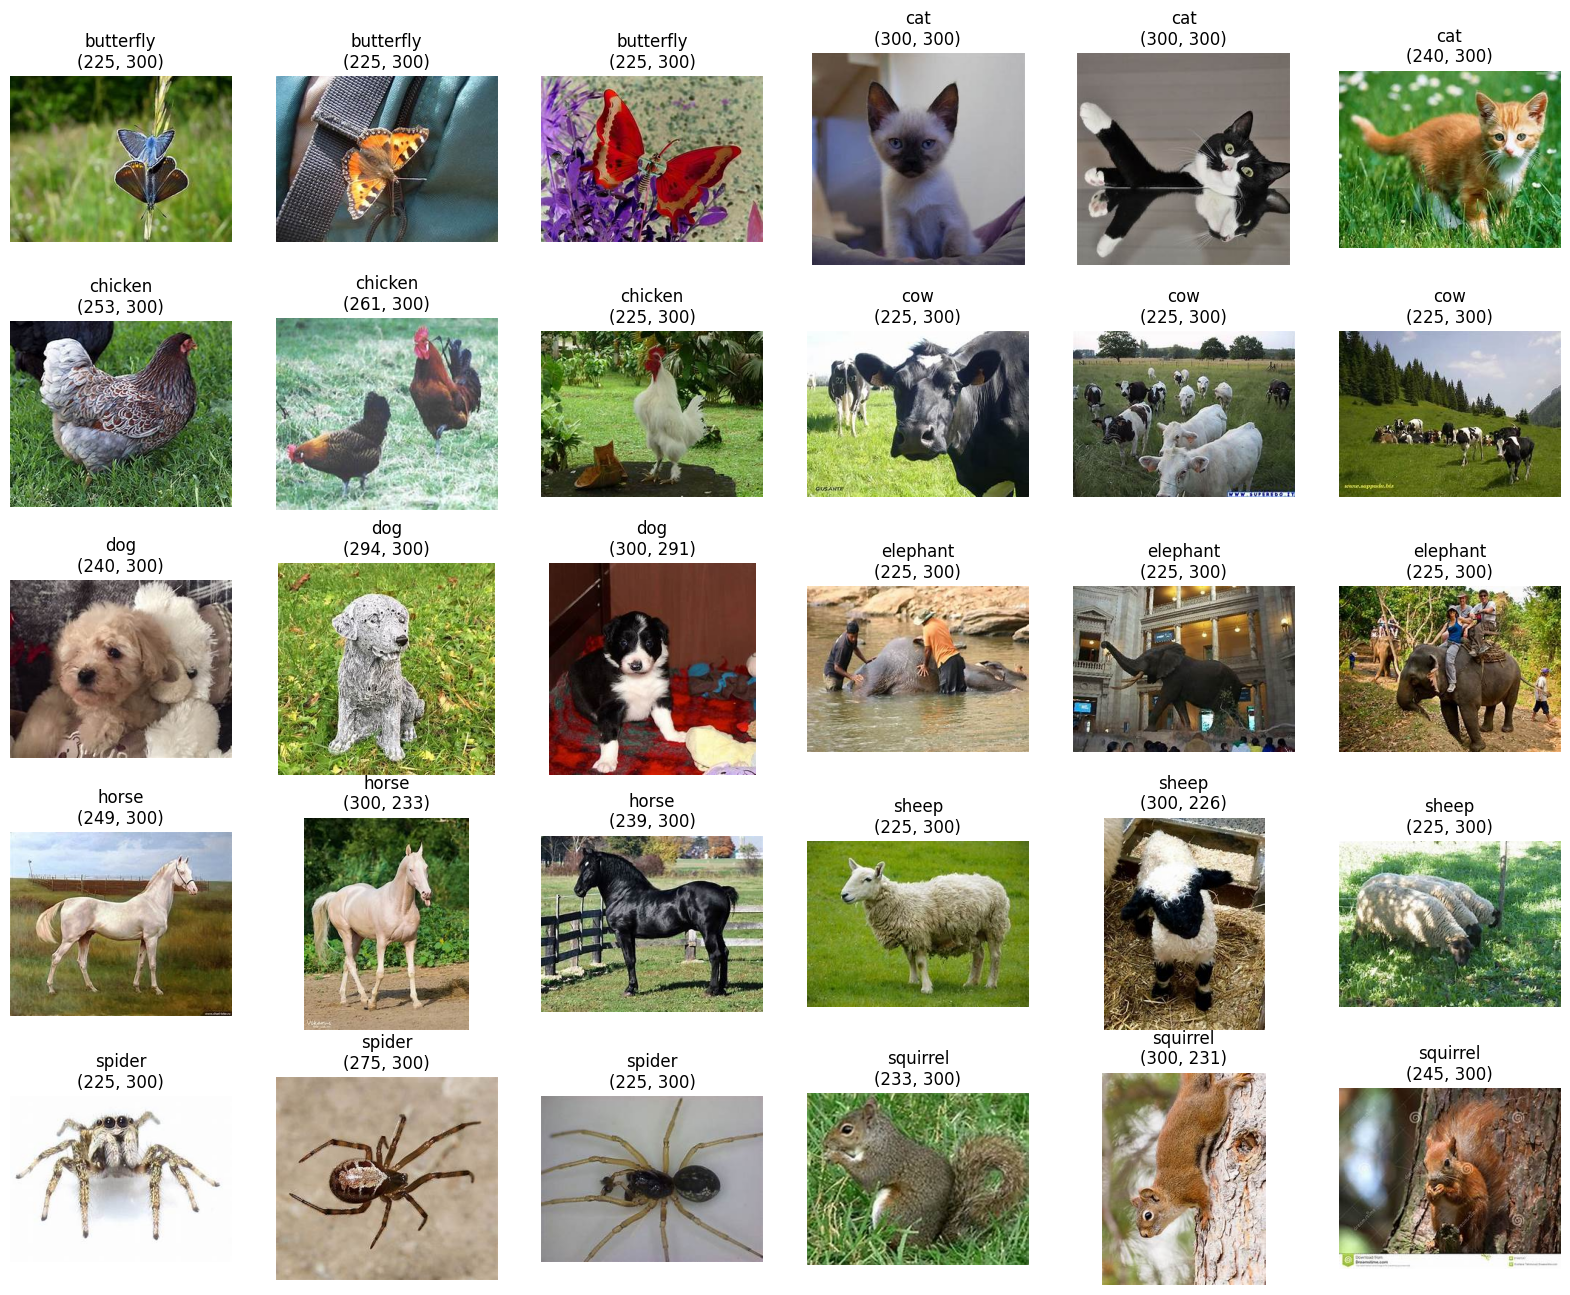

In [21]:
# Show a few examples
plt.figure(figsize=(20, 16))
for i, label in enumerate(df['target'].unique()):
  subset = df['path'][df['target'] == label].sample(3, random_state=0)
  for j in range(3):
    plt.subplot(5, 6, 3*i+j+1)
    img = plt.imread(subset.iloc[j])
    plt.imshow(img)
    plt.title(f'{label}\n{img.shape[:2]}')
    plt.axis('off')

## 1.4 Separe os conjuntos de dados entre treino, treino reduzido, validação e teste conforme especificado na introdução

In [23]:
# Train/val/test split (with the same number of images per class)

images_per_class = 25
random_state = 0
n_classes = len(df['target'].unique())

df_train_val,   df_test = train_test_split(df,            test_size=images_per_class*n_classes, stratify=df['target'],           random_state=random_state)
df_train,       df_val  = train_test_split(df_train_val,  test_size=images_per_class*n_classes, stratify=df_train_val['target'], random_state=random_state)
df_train_small, _       = train_test_split(df_train,     train_size=images_per_class*n_classes, stratify=df_train['target'],     random_state=random_state)

print(f'Train set (full)  : {len(df_train):4d} images ({int(len(df_train)/n_classes):3d} per class)')
print(f'Train set (small) : {len(df_train_small):4d} images ({int(len(df_train_small)/n_classes):3d} per class)')
print(f'Validation set    : {len(df_val):4d} images ({int(len(df_val)/n_classes):3d} per class)')
print(f'Test set          : {len(df_test):4d} images ({int(len(df_test)/n_classes):3d} per class)')

Train set (full)  : 1000 images (100 per class)
Train set (small) :  250 images ( 25 per class)
Validation set    :  250 images ( 25 per class)
Test set          :  250 images ( 25 per class)


## 2. Desenvolvimento principal
